In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import json
import os
import evaluate
import datasets

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#single task - 135
path_cluster = 'output_multitask/experiments/SmolLM-135M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719202940/evals'
path_fedavg =  'output_multitask/experiments/SmolLM-135M/fedavg_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719202847/evals'
path_router =  'output_multitask/experiments/SmolLM-135M/ROUTER_evallocal_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720104636/evals'

#single task - 360
path_cluster = 'output_multitask/dev_experiments/SmolLM-360M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250718135612/evals'
path_fedavg =  'output_multitask/dev_experiments/SmolLM-360M/fedavg_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250715085715/evals'
path_router =  'output_multitask/experiments/SmolLM-360M/ROUTER_evallocal_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720111429/evals'

#multidomain
path_cluster = 'output_multitask/experiments/SmolLM-135M/clustered_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250717090719/evals'
path_fedavg = 'output_multitask/experiments/SmolLM-135M/fedavg_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250717090535/evals'
path_router = 'output_multitask/experiments/SmolLM-135M/ROUTER_evallocal_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720104548/evals'

#longer - 100 rounds
#path_cluster = 'output_multitask/dev_experiments/SmolLM-360M/clustered_longer_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250714135710/evals'
#path_fedavg = 'output_multitask/dev_experiments/SmolLM-360M/fedavg_longer_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250714135629/evals'
#path_router = 'output_multitask/experiments/SmolLM-360M/ROUTER_evallocal_smulti_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720111509/evals'

#even greater model
path_cluster = 'output_multitask/experiments/SmolLM-1.7B/clustered_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250721085551/evals'
path_fedavg = 'output_multitask/dev_experiments/SmolLM-1.7B/fedavg_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250717082756/evals'
path_router = 'output_multitask/experiments/SmolLM-1.7B/ROUTER_evallocal_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720193838/evals'

#100 steps
#path_cluster = ''
#path_fedavg = 'output_multitask/dev_experiments/SmolLM-360M/fedavg_moresteps_multi_domain_multitask_clustered_c8s8_i100_b16a1_l1024_r8a16_20250715160144/evals'
#path_router = 'output_multitask/dev_experiments/SmolLM-360M/ROUTER_teste_moresteps_multi_domain_multitask_router_c8s8_i100_b16a1_l1024_r8a16_20250715155941/evals'

#aya
#path_cluster = 'output_aya/dev_experiments/SmolLM-135M/clustered_single_domain_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250713082953/evals'
#path_fedavg = 'output_aya/dev_experiments/SmolLM-135M/fedavg_single_domain_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250713082912/evals'
#path_router = 'output_aya/dev_experiments/SmolLM-135M/ROUTER_single_domain_aya_dataset_router_c10s10_i10_b16a1_l1024_r8a16_20250713082837/evals'

#aya - multi
#path_cluster = 'output_aya/dev_experiments/SmolLM-135M/clustered_multi_domain_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250713152223/evals'
#path_fedavg = 'output_aya/dev_experiments/SmolLM-135M/fedavg_multi_domain_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250713152256/evals'
#path_router = 'output_aya/dev_experiments/SmolLM-135M/ROUTER_multi_domain_aya_dataset_router_c10s10_i10_b16a1_l1024_r8a16_20250713152205/evals'

total_examples = 100
round = 100

In [4]:
def read_results(path, round):
    results = {}
    for result in os.listdir(path):
        if result.endswith(f'_{round}.json'):
            with open(os.path.join(path, result), 'r') as f:
                data = json.load(f)
            
            client = result.split('client_')[-1].split('_')[0]

            if client not in results:
                results[client] = data["rouge1"] * (data["dataset_length"] / total_examples)
            else:
                results[client] += data["rouge1"] * (data["dataset_length"] / total_examples)
    return results

In [5]:
def read_results_by_cluster(path, round):
    results = {}
    for result in os.listdir(path):
        if result.endswith(f'_{round}.json'):
            cluster = result.split('cluster_')[-1].split('_')[0]
            with open(os.path.join(path, result), 'r') as f:
                data = json.load(f)
            if cluster not in results:
                results[cluster] = [data["rouge1"]]
            else:
                results[cluster].append(data["rouge1"])
    for cluster in results:
        results[cluster] = np.mean(results[cluster])
    return results

In [6]:
results_router = read_results(path_router, round)
results_cluster = read_results(path_cluster, round)
results_fedavg = read_results(path_fedavg, round)

In [7]:
results_router

{'0': 0.3584857306436252,
 '1': 0.37703961349435566,
 '3': 0.34835614732697673,
 '2': 0.36136282931217023,
 '7': 0.7265769777759861,
 '6': 0.6837548923855914,
 '4': 0.6374107415294521,
 '5': 0.6233863359569906}

In [8]:
results_fedavg

{'3': 0.31984444451847927,
 '2': 0.33128344737890736,
 '0': 0.3491814258325094,
 '1': 0.3740654586846872,
 '4': 0.6459301777985683,
 '5': 0.6325135841648872,
 '7': 0.7158038225223178,
 '6': 0.6746902967128295}

In [9]:
results_cluster

{'1': 0.34599610611901965,
 '0': 0.3315960167208988,
 '6': 0.6853393095612677,
 '7': 0.7037345279058764,
 '5': 0.6485095140769874,
 '4': 0.6672892071327936,
 '2': 0.36845296450141163,
 '3': 0.3509557548730574}

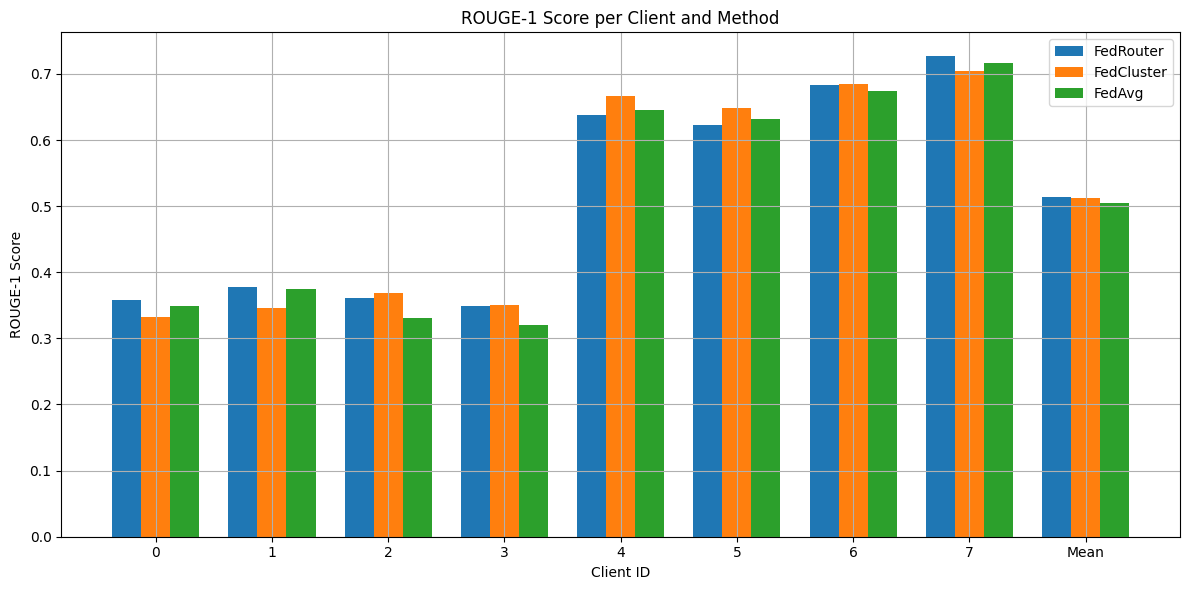

In [10]:
# Get all unique client IDs
client_ids = sorted(set(list(results_cluster.keys()) + list(results_fedavg.keys()) + list(results_router.keys())))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of the bars
width = 0.25

# Set the positions of the bars on the x-axis
x = np.arange(len(client_ids)+1)

mean_all_router = np.mean(list(results_router.values()))
mean_all_cluster = np.mean(list(results_cluster.values()))
mean_all_fedavg = np.mean(list(results_fedavg.values()))

# Create bars for each method
router_bars = ax.bar(x - width, [results_router.get(client, 0) for client in client_ids] + [mean_all_router], width, label='FedRouter')
cluster_bars = ax.bar(x, [results_cluster.get(client, 0) for client in client_ids] + [mean_all_cluster], width, label='FedCluster')
fedavg_bars = ax.bar(x + width, [results_fedavg.get(client, 0) for client in client_ids] + [mean_all_fedavg], width, label='FedAvg')

# Add labels, title, and legend
ax.set_xlabel('Client ID')
ax.set_ylabel('ROUGE-1 Score')
ax.set_title('ROUGE-1 Score per Client and Method')
ax.set_xticks(x)
ax.set_xticklabels(client_ids + ['Mean'])
ax.legend()

# Ensure the plot looks good
plt.tight_layout()
plt.grid()

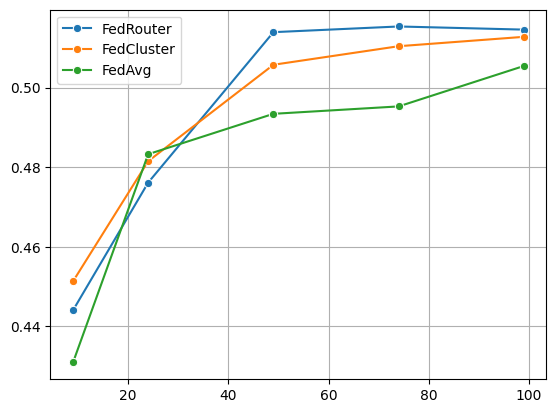

In [11]:
rounds = [9, 24, 49, 74, 99]

means_router = []
means_cluster = []
means_fedavg = []

for r in rounds:
    results_router = read_results(path_router, r+1)
    results_cluster = read_results(path_cluster, r+1)
    results_fedavg = read_results(path_fedavg, r+1)

    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')

#plt.ylim(0,1)
plt.grid()

Text(0.5, 1.0, 'Smol 135M for Single Domain Tasks')

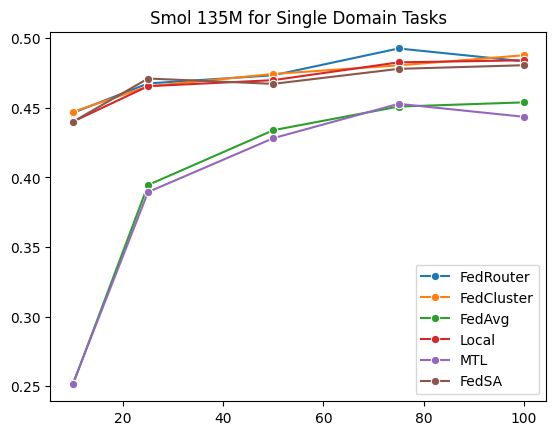

In [12]:
#single task - 135
path_cluster = 'output_multitask/experiments/SmolLM-135M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719202940/evals'
path_fedavg =  'output_multitask/experiments/SmolLM-135M/fedavg_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719202847/evals'
path_router =  'output_multitask/experiments/SmolLM-135M/ROUTER_evallocal_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720104636/evals'
path_local = 'output_multitask/experiments/SmolLM-135M/local_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719202753/evals'
path_mtl = 'output_multitask/experiments/SmolLM-135M/MTL_single_domain_multitask_MTL_c8s8_i10_b16a1_l1024_r8a16_20250719203217/evals'
path_fedsa = 'output_multitask/experiments/SmolLM-135M/FedSA_single_domain_multitask_FedSA_c8s8_i10_b16a1_l1024_r8a16_20250719203136/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    results_local = read_results(path_local, r)
    results_mtl = read_results(path_mtl, r)
    results_fedsa = read_results(path_fedsa, r)


    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    mean_all_local = np.mean(list(results_local.values()))
    mean_all_mtl = np.mean(list(results_mtl.values()))
    mean_all_fedsa = np.mean(list(results_fedsa.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    means_local.append(mean_all_local)
    means_mtl.append(mean_all_mtl)
    means_fedsa.append(mean_all_fedsa)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 135M for Single Domain Tasks')


Text(0.5, 1.0, 'Smol 135M for Multi Domain Tasks')

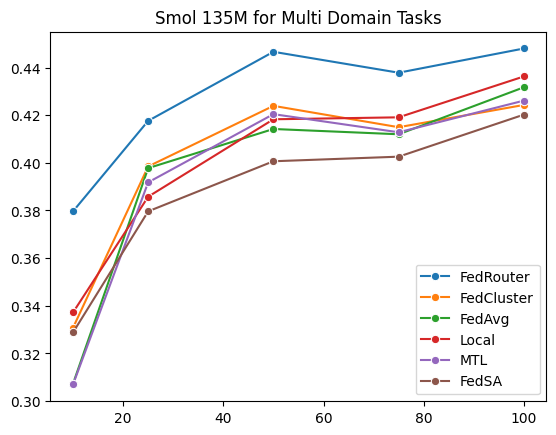

In [13]:
#multi task - 135
path_cluster = 'output_multitask/experiments/SmolLM-135M/clustered_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250717090719/evals'
path_fedavg =  'output_multitask/experiments/SmolLM-135M/fedavg_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250717090535/evals'
path_router =  'output_multitask/experiments/SmolLM-135M/ROUTER_evallocal_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720104548/evals'
path_local = 'output_multitask/experiments/SmolLM-135M/local_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250720082018/evals'
path_mtl = 'output_multitask/experiments/SmolLM-135M/MTL_multi_domain_multitask_MTL_c8s8_i10_b16a1_l1024_r8a16_20250719203938/evals'
path_fedsa = 'output_multitask/experiments/SmolLM-135M/FedSA_multi_domain_multitask_FedSA_c8s8_i10_b16a1_l1024_r8a16_20250719204032/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    results_local = read_results(path_local, r)
    results_mtl = read_results(path_mtl, r)
    results_fedsa = read_results(path_fedsa, r)


    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    mean_all_local = np.mean(list(results_local.values()))
    mean_all_mtl = np.mean(list(results_mtl.values()))
    mean_all_fedsa = np.mean(list(results_fedsa.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    means_local.append(mean_all_local)
    means_mtl.append(mean_all_mtl)
    means_fedsa.append(mean_all_fedsa)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 135M for Multi Domain Tasks')

Text(0.5, 1.0, 'Smol 135M for IID Domain Tasks')

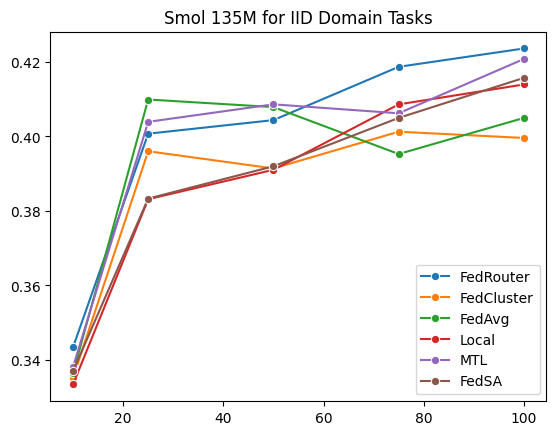

In [22]:
#multi task - 135
path_cluster = 'output_multitask/experiments/SmolLM-135M/clustered_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250722075606/evals'
path_fedavg =  'output_multitask/experiments/SmolLM-135M/fedavg_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250722075633/evals'
path_router =  'output_multitask/experiments/SmolLM-135M/ROUTER_evallocal_iid_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250722075455/evals'
path_local = 'output_multitask/experiments/SmolLM-135M/local_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250722151518/evals'
path_mtl = 'output_multitask/experiments/SmolLM-135M/MTL_iid_multitask_MTL_c8s8_i10_b16a1_l1024_r8a16_20250722133628/evals'
path_fedsa = 'output_multitask/experiments/SmolLM-135M/FedSA_iid_multitask_FedSA_c8s8_i10_b16a1_l1024_r8a16_20250722133111/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    results_local = read_results(path_local, r)
    results_mtl = read_results(path_mtl, r)
    results_fedsa = read_results(path_fedsa, r)

    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    mean_all_local = np.mean(list(results_local.values()))
    mean_all_mtl = np.mean(list(results_mtl.values()))
    mean_all_fedsa = np.mean(list(results_fedsa.values()))


    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    means_local.append(mean_all_local)
    means_mtl.append(mean_all_mtl)
    means_fedsa.append(mean_all_fedsa)


sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 135M for IID Domain Tasks')

Text(0.5, 1.0, 'Smol 360M for Single Domain Tasks')

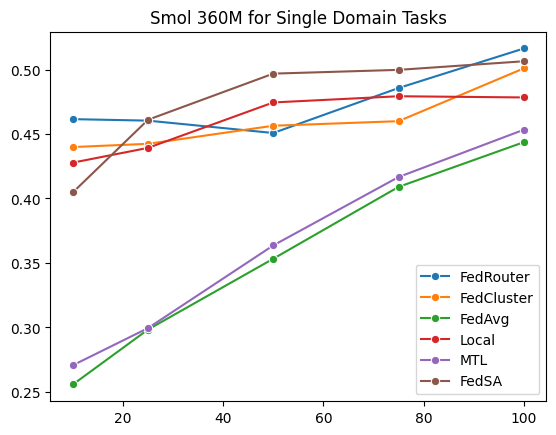

In [15]:
#single task - 360
path_cluster = 'output_multitask/dev_experiments/SmolLM-360M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250718135612/evals'
path_fedavg =  'output_multitask/dev_experiments/SmolLM-360M/fedavg_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250715085715/evals'
path_router =  'output_multitask/experiments/SmolLM-360M/ROUTER_evallocal_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720111429/evals'
path_local = 'output_multitask/dev_experiments/SmolLM-360M/local_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250719085101/evals'
path_mtl = 'output_multitask/dev_experiments/SmolLM-360M/MTL_single_domain_multitask_MTL_c8s8_i10_b16a1_l1024_r8a16_20250719084444/evals'
path_fedsa = 'output_multitask/dev_experiments/SmolLM-360M/FedSA_single_domain_multitask_FedSA_c8s8_i10_b16a1_l1024_r8a16_20250717160904/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    results_local = read_results(path_local, r)
    results_mtl = read_results(path_mtl, r)
    results_fedsa = read_results(path_fedsa, r)


    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    mean_all_local = np.mean(list(results_local.values()))
    mean_all_mtl = np.mean(list(results_mtl.values()))
    mean_all_fedsa = np.mean(list(results_fedsa.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    means_local.append(mean_all_local)
    means_mtl.append(mean_all_mtl)
    means_fedsa.append(mean_all_fedsa)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 360M for Single Domain Tasks')

Text(0.5, 1.0, 'Smol 360M for Multi Domain Tasks')

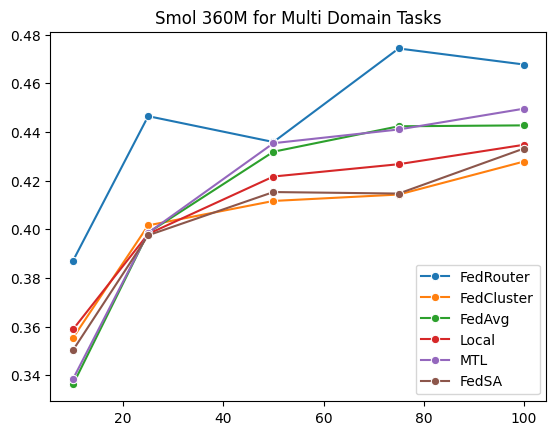

In [16]:
#single task - 360
path_cluster = 'output_multitask/dev_experiments/SmolLM-360M/clustered_longer_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250714135710/evals'
path_fedavg =  'output_multitask/dev_experiments/SmolLM-360M/fedavg_longer_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250714135629/evals'
path_router =  'output_multitask/experiments/SmolLM-360M/ROUTER_evallocal_smulti_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250720111509/evals'
path_local = 'output_multitask/experiments/SmolLM-360M/local_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250720182527/evals'
path_mtl = 'output_multitask/dev_experiments/SmolLM-360M/FedMTL_multi_domain_multitask_MTL_c8s8_i10_b16a1_l1024_r8a16_20250717144928/evals'
path_fedsa = 'output_multitask/dev_experiments/SmolLM-360M/FedSA_multi_domain_multitask_FedSA_c8s8_i10_b16a1_l1024_r8a16_20250717101254/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    results_local = read_results(path_local, r)
    results_mtl = read_results(path_mtl, r)
    results_fedsa = read_results(path_fedsa, r)

    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    mean_all_local = np.mean(list(results_local.values()))
    mean_all_mtl = np.mean(list(results_mtl.values()))
    mean_all_fedsa = np.mean(list(results_fedsa.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    means_local.append(mean_all_local)
    means_mtl.append(mean_all_mtl)
    means_fedsa.append(mean_all_fedsa)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 360M for Multi Domain Tasks')

In [ ]:
path_cluster = 'output_multitask/experiments/SmolLM-360M/clustered_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250723081716/evals'
path_fedavg =  'output_multitask/experiments/SmolLM-360M/fedavg_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250723081702/evals'
path_router =  'output_multitask/experiments/SmolLM-360M/ROUTER_evallocal_iid_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250723081123/evals'

rounds = [10,25,50,75,100]

means_router = []
means_cluster = []
means_fedavg = []
means_local = []
means_mtl = []
means_fedsa = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_cluster = read_results(path_cluster, r)
    results_fedavg = read_results(path_fedavg, r)
    #results_local = read_results(path_local, r)
    #results_mtl = read_results(path_mtl, r)
    #results_fedsa = read_results(path_fedsa, r)

    mean_all_router = np.mean(list(results_router.values()))
    mean_all_cluster = np.mean(list(results_cluster.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))
    #mean_all_local = np.mean(list(results_local.values()))
    #mean_all_mtl = np.mean(list(results_mtl.values()))
    #mean_all_fedsa = np.mean(list(results_fedsa.values()))

    means_router.append(mean_all_router)
    means_cluster.append(mean_all_cluster)
    means_fedavg.append(mean_all_fedavg)
    #means_local.append(mean_all_local)
    #means_mtl.append(mean_all_mtl)
    #means_fedsa.append(mean_all_fedsa)

sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_cluster, label='FedCluster', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')
#sns.lineplot(x=rounds, y=means_local, label='Local', marker='o')
#sns.lineplot(x=rounds, y=means_mtl, label='MTL', marker='o')
#sns.lineplot(x=rounds, y=means_fedsa, label='FedSA', marker='o')

plt.title('Smol 360M for IID Domain Tasks')

FileNotFoundError: [Errno 2] No such file or directory: 'output_multitask/experiments/SmolLM-360M/fedavg_iid_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250723081702/checkpoint-0/evals'

In [17]:
results_router = read_results_by_cluster(path_router, r+1)
results_router

{}

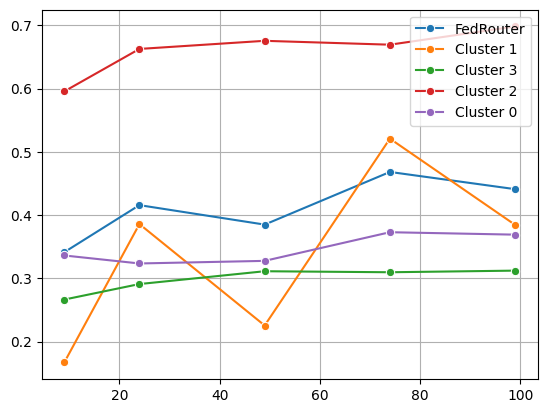

In [18]:
#plot line plot by clusters in fed router
rounds = [9, 24, 49, 74, 99]
means_router = []
results_clusters = {}
for r in rounds:
    results_router = read_results_by_cluster(path_router, r+1)
    for cluster, score in results_router.items():
        if cluster not in results_clusters:
            results_clusters[cluster] = []
        results_clusters[cluster].append(score)
    means_router.append(np.mean(list(results_router.values())))
sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
for cluster, scores in results_clusters.items():
    sns.lineplot(x=rounds, y=scores, label=f'Cluster {cluster}', marker='o')
plt.grid()





In [19]:
path_router = 'output_multitask/dev_experiments/SmolLM-135M/ROUTER_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250711093154/evals'
path_router_more_comp = 'output_multitask/dev_experiments/SmolLM-135M/ROUTER_comp_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250711125047/evals'
path_router_ajust_comp = 'output_multitask/dev_experiments/SmolLM-135M/ROUTER_comp_RR_ajust_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250712082014/evals'
path_router_ajust_comp_random = 'output_multitask/dev_experiments/SmolLM-135M/ROUTER_comp_ajust_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250712081934/evals'
path_fedavg = 'output_multitask/dev_experiments/SmolLM-135M/fedavg_multi_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250711122052/evals'

total_examples = 100
round = 49

In [20]:
results_router = read_results(path_router, round)
results_router_more_comp = read_results(path_router_more_comp, round+1)
results_router_ajust_comp = read_results(path_router_ajust_comp, round+1)
results_router_ajust_comp_random = read_results(path_router_ajust_comp_random, round+1)
results_fedavg = read_results(path_fedavg, round)

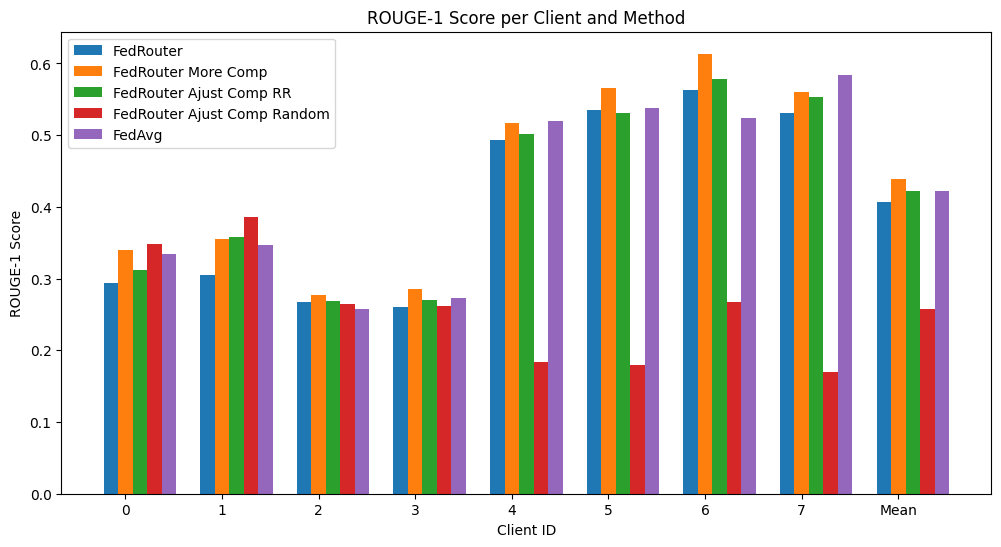

In [572]:
client_ids = sorted(set(list(results_router.keys()) + list(results_router_more_comp.keys()) + list(results_router_ajust_comp.keys()) + list(results_router_ajust_comp_random.keys()) + list(results_fedavg.keys())))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
# Set the width of the bars

width = 0.15

# Set the positions of the bars on the x-axis
x = np.arange(len(client_ids)+1)
mean_all_router = np.mean(list(results_router.values()))
mean_all_router_more_comp = np.mean(list(results_router_more_comp.values()))
mean_all_router_ajust_comp = np.mean(list(results_router_ajust_comp.values()))
mean_all_router_ajust_comp_random = np.mean(list(results_router_ajust_comp_random.values()))
mean_all_fedavg = np.mean(list(results_fedavg.values()))

# Create bars for each method
router_bars = ax.bar(x - width, [results_router.get(client, 0)
                                for client in client_ids] + [mean_all_router], width, label='FedRouter')
router_more_comp_bars = ax.bar(x, [results_router_more_comp.get(client, 0)
                                    for client in client_ids] + [mean_all_router_more_comp], width, label='FedRouter More Comp')
router_ajust_comp_bars = ax.bar(x + width, [results_router_ajust_comp.get(client, 0)
                                        for client in client_ids] + [mean_all_router_ajust_comp], width, label='FedRouter Ajust Comp RR')
router_ajust_comp_random_bars = ax.bar(x + 2*width, [results_router_ajust_comp_random.get(client, 0)
                                        for client in client_ids] + [mean_all_router_ajust_comp_random], width, label='FedRouter Ajust Comp Random')
fedavg_bars = ax.bar(x + 3*width, [results_fedavg.get(client, 0)
                                    for client in client_ids] + [mean_all_fedavg], width, label='FedAvg')

# Add labels, title, and legend
ax.set_xlabel('Client ID')
ax.set_ylabel('ROUGE-1 Score')
ax.set_title('ROUGE-1 Score per Client and Method')
ax.set_xticks(x)
ax.set_xticklabels(client_ids + ['Mean'])
ax.legend()


<Axes: >

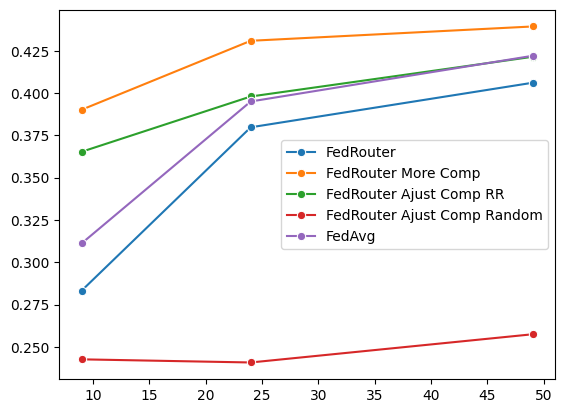

In [83]:
rounds = [9, 24, 49]
means_router = []
means_router_more_comp = []
means_router_ajust_comp = []
means_router_ajust_comp_random = []
means_fedavg = []

for r in rounds:
    results_router = read_results(path_router, r)
    results_router_more_comp = read_results(path_router_more_comp, r+1)
    results_router_ajust_comp = read_results(path_router_ajust_comp, r+1)
    results_router_ajust_comp_random = read_results(path_router_ajust_comp_random, r+1)
    results_fedavg = read_results(path_fedavg, r)

    mean_all_router = np.mean(list(results_router.values()))
    mean_all_router_more_comp = np.mean(list(results_router_more_comp.values()))
    mean_all_router_ajust_comp = np.mean(list(results_router_ajust_comp.values()))
    mean_all_router_ajust_comp_random = np.mean(list(results_router_ajust_comp_random.values()))
    mean_all_fedavg = np.mean(list(results_fedavg.values()))

    means_router.append(mean_all_router)
    means_router_more_comp.append(mean_all_router_more_comp)    
    means_router_ajust_comp.append(mean_all_router_ajust_comp)
    means_router_ajust_comp_random.append(mean_all_router_ajust_comp_random)
    means_fedavg.append(mean_all_fedavg)


sns.lineplot(x=rounds, y=means_router, label='FedRouter', marker='o')
sns.lineplot(x=rounds, y=means_router_more_comp, label='FedRouter More Comp', marker='o')
sns.lineplot(x=rounds, y=means_router_ajust_comp, label='FedRouter Ajust Comp RR', marker='o')
sns.lineplot(x=rounds, y=means_router_ajust_comp_random, label='FedRouter Ajust Comp Random', marker='o')
sns.lineplot(x=rounds, y=means_fedavg, label='FedAvg', marker='o')

In [39]:
loss

array([ 1.34277573e+00,  8.24363327e-02,  9.89678955e-02,  4.84844971e-02,
        8.43438339e-02,  4.18658066e-02,  5.01558685e-02,  1.30132294e-02,
        5.86493301e-02, -8.74065399e-03,  4.11672211e-02,  1.33293152e-03,
        3.38341141e-02, -6.34502411e-03,  2.48976517e-02, -1.45718002e-02,
        1.81344223e-02, -1.12363052e-02,  2.64835358e-02, -1.04301453e-03,
        1.28025818e-02, -3.25898361e-02,  1.21612549e-03, -2.59778214e-02,
        1.27811432e-03, -2.96405029e-02, -8.18248749e-03, -3.40868759e-02,
        2.53261566e-03, -1.87744904e-02,  5.73333740e-03, -2.97626877e-02,
       -1.44550705e-02, -4.80382919e-02, -9.27284241e-03, -2.77534485e-02,
       -2.02700424e-02, -4.26378250e-02,  5.36804199e-04, -5.11236572e-02,
       -1.91452408e-02, -4.74367142e-02, -1.52943039e-02, -5.07034302e-02,
       -2.69303894e-02, -5.10042953e-02, -2.44557571e-02, -4.20362854e-02,
       -1.37642288e-02, -4.57491302e-02, -3.20044708e-02, -5.69680023e-02,
       -2.27153397e-02, -

(0.0, 100.0)

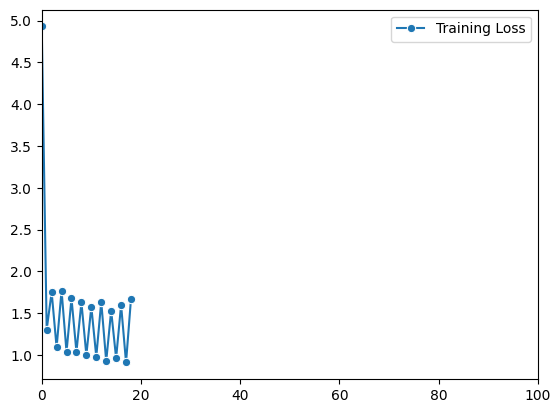

In [29]:
loss = np.load('output_multitask/dev_experiments/SmolLM-360M/ROUTER_correction_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250716083750/training_loss.npy')[5]

loss  = loss*2
loss = loss + np.ones_like(loss)

sns.lineplot(x=range(len(loss)), y=loss, label='Training Loss', marker='o')
plt.xlim(0, 100)

<Axes: >

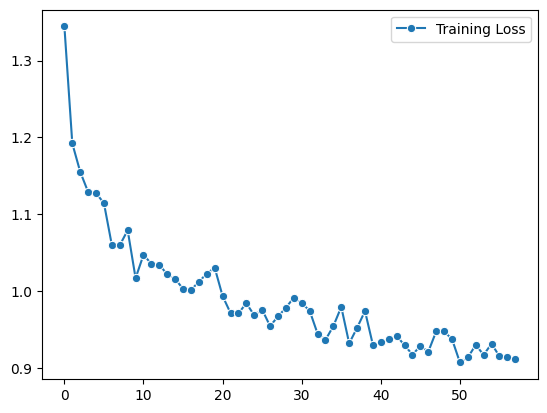

In [28]:
loss = np.load('output_multitask/dev_experiments/SmolLM-360M/fedavg_moresteps_multi_domain_multitask_clustered_c8s8_i100_b16a1_l1024_r8a16_20250715160144/training_loss.npy')[5]

sns.lineplot(x=range(len(loss)), y=loss, label='Training Loss', marker='o')

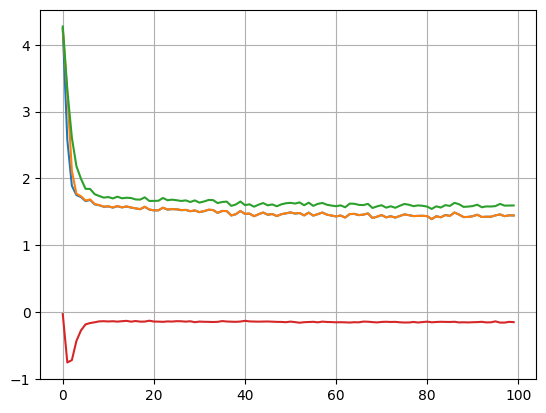

In [79]:
loss_router = 'output_multitask/new_eval_multitask/SmolLM-135M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250707142010/training_loss.npy'
loss_router = np.load(loss_router)
sns.lineplot(y= loss_router.mean(axis=0), x= np.arange(loss_router.shape[1]))

loss_clustered = 'output_multitask/new_eval_multitask_big/SmolLM-135M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250707190955/training_loss.npy'
loss_clustered = np.load(loss_clustered)
sns.lineplot(y= loss_clustered.mean(axis=0), x= np.arange(loss_clustered.shape[1]))

loss_fedavg = 'output_multitask/new_eval_multitask_big/SmolLM-135M/fedavg_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250707144831/training_loss.npy'
loss_fedavg = np.load(loss_fedavg)
sns.lineplot(y= loss_fedavg.mean(axis=0), x= np.arange(loss_fedavg.shape[1]))

diff = loss_router.mean(axis=0) - loss_fedavg.mean(axis=0)
sns.lineplot(y= diff, x= np.arange(loss_router.shape[1]))

plt.grid()

In [117]:
dataset_path = 'output_multitask/experiments/SmolLM-135M/ROUTER_correction_multi_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250718075555/clients_train_datasets/client_7_round_0/data-00000-of-00001.arrow'

dataset_train = datasets.load_dataset('arrow', data_files=dataset_path, split='train')

Generating train split: 8968 examples [00:00, 43231.70 examples/s]


In [118]:
print(np.unique(dataset_train['task'], return_counts=True))
print(np.unique(dataset_train['cluster_label'], return_counts=True))

(array(['boolq', 'webnlg'], dtype='<U6'), array([1872, 7096]))
(array([0, 1]), array([1987, 6981]))


In [15]:
cluters_path = 'output_multitask/dev_experiments/SmolLM-360M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250718135518/centers/global_clusters_1.npy'
clusters = np.load(cluters_path)
clusters

array([3, 3, 1, 1, 0, 0, 2, 2], dtype=int32)

In [120]:
# 3 dutch
# 2 english
# 1 Turkish
# 0 Portuguese
# 4 spanish

In [121]:
cluster_labels = dataset_train['cluster_label']
tasks = dataset_train['task']

unique_tasks = set(tasks)
print("Unique tasks:", unique_tasks)

Unique tasks: {'boolq', 'webnlg'}


In [123]:
task_mapping = {
    'webnlg': 0,
    'boolq': 1
}

# Convert task names to numerical labels
tasks = [task_mapping[task] for task in tasks]

#accuracy

from sklearn.metrics import accuracy_score

y_true = cluster_labels
y_pred = tasks

print("Accuracy:", accuracy_score(y_true, y_pred))
print("ALternative Accuracy:", 1 - accuracy_score(y_true, y_pred))


Accuracy: 0.013938447814451383
ALternative Accuracy: 0.9860615521855486


In [ ]:
path = 'output_multitask/new_eval_multitask/SmolLM-135M/clustered_single_domain_multitask_clustered_c8s8_i10_b16a1_l1024_r8a16_20250707095245/clusters_round1.npy'
clusters = np.load(path)
clusters

array([1, 1, 2, 2, 3, 3, 4, 4], dtype=int32)

In [13]:
import datasets
import numpy as np

all_datasets = []
for c in  range(0, 8):
    path = f'output_multitask/new_eval_multitask/SmolLM-135M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250707092128/clients_test_datasets/client_{c}_round_9/data-00000-of-00001.arrow'
    all_datasets.append(datasets.load_dataset('arrow', data_files=path, split='train'))

In [14]:
int(clusters[0])

1

In [15]:
from transformers import AutoModelForCausalLM
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer
import datasets
import numpy as np

model = AutoModelForCausalLM.from_pretrained(
        'HuggingFaceTB/SmolLM-135M',
        device_map='auto',
        trust_remote_code=True,
        #quantization_config={"load_in_4bit": True,
        #                     "bnb_4bit_quant_type": "nf4", 
        #                        "bnb_4bit_compute_dtype": "float16",
        #                        "bnb_4bit_use_double_quant": True})
)
tokenizer = AutoTokenizer.from_pretrained(
    'HuggingFaceTB/SmolLM-135M', 
    use_fast=False, 
    padding_side="left"
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if tokenizer.eos_token == tokenizer.unk_token or tokenizer.pad_token == tokenizer.eos_token:
        tokenizer.add_special_tokens({'pad_token': '<pad>'})
        print(f"Pad token is set to {tokenizer.pad_token}.")

model.resize_token_embeddings(len(tokenizer))

texts = []
labels_clients = []
for cid, dataset in enumerate(all_datasets):
    texts.extend(dataset['instruction'])
    labels_clients.extend([clusters[cid]] * len(dataset['instruction']))

embeddings_list = []

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Pad token is set to <pad>.


In [16]:
def get_embeddings_model(texts, model, tokenizer):
    with torch.no_grad():
        inputs = tokenizer(
            texts, 
            return_tensors='pt', 
            padding='longest', 
            truncation=True, 
            max_length=1024,
            padding_side='left'
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(inputs['input_ids'], output_hidden_states=True, attention_mask=inputs['attention_mask'])
        # Get the last hidden state
        last_hidden_state = outputs.hidden_states[-1]
        attention_mask = inputs['attention_mask'].unsqueeze(-1)

        # Apply mask to zero out padding tokens
        masked_hidden_states = last_hidden_state * attention_mask

        # Sum and divide by the number of actual tokens (not padding)
        sum_hidden_states = masked_hidden_states.sum(dim=1)
        token_counts = attention_mask.sum(dim=1)

        # Avoid division by zero
        token_counts = torch.clamp(token_counts, min=1.0)

        # Calculate average excluding padding tokens
        embeddings = sum_hidden_states / token_counts
    return embeddings

In [17]:
batch_size = 32
for i in range(0, len(texts), batch_size):
        batch_texts = texts[i: i + batch_size]
        batch_embeddings = get_embeddings_model(batch_texts, model, tokenizer)
        # Convert to CPU numpy array with float16 precision
        batch_embeddings = batch_embeddings.to(torch.float16).cpu().numpy()
        embeddings_list.append(batch_embeddings)
        
embeddings = np.concatenate(embeddings_list, axis=0)
print(f"Embeddings shape: {embeddings.shape}")

Embeddings shape: (800, 576)


In [18]:
path = 'output_multitask/new_eval_multitask/SmolLM-135M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250707092128/centers/centroids_1.npy'
centers = np.load(path)

In [19]:
path_client_embeddings = 'output_multitask/new_eval_multitask/SmolLM-135M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250707092128/centers/client_embeddings_1.npy'
client_embeddings_raw = np.load(path_client_embeddings, allow_pickle=True).item()

In [20]:
client_embeddings = []
for i in range(8):
    client_embeddings.append(client_embeddings_raw[i][0])

In [21]:
embeddings_client_sim = []
embeddings_client_labels = []
center_client = []

for c in range(8):

    embeddings_client_path_sim = f'output_multitask/new_eval_multitask/SmolLM-135M/ROUTER_single_domain_multitask_router_c8s8_i10_b16a1_l1024_r8a16_20250707092128/client_test_datasets/embeddings/test_embeddings_{c}_round_10.npy'
    embeddings_client_sim_i = np.load(embeddings_client_path_sim, allow_pickle=True)

    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(embeddings_client_sim_i)

    centers_inferred = kmeans.cluster_centers_[0]
    center_client.append(centers_inferred)

    if c == 0:
        embeddings_client_sim = embeddings_client_sim_i
        embeddings_client_labels = [c] * embeddings_client_sim_i.shape[0]
    else:   
        embeddings_client_sim = np.concatenate((embeddings_client_sim, embeddings_client_sim_i), axis=0)
        embeddings_client_labels.extend([c] * embeddings_client_sim_i.shape[0])

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(center_client)

centers_server = kmeans.cluster_centers_

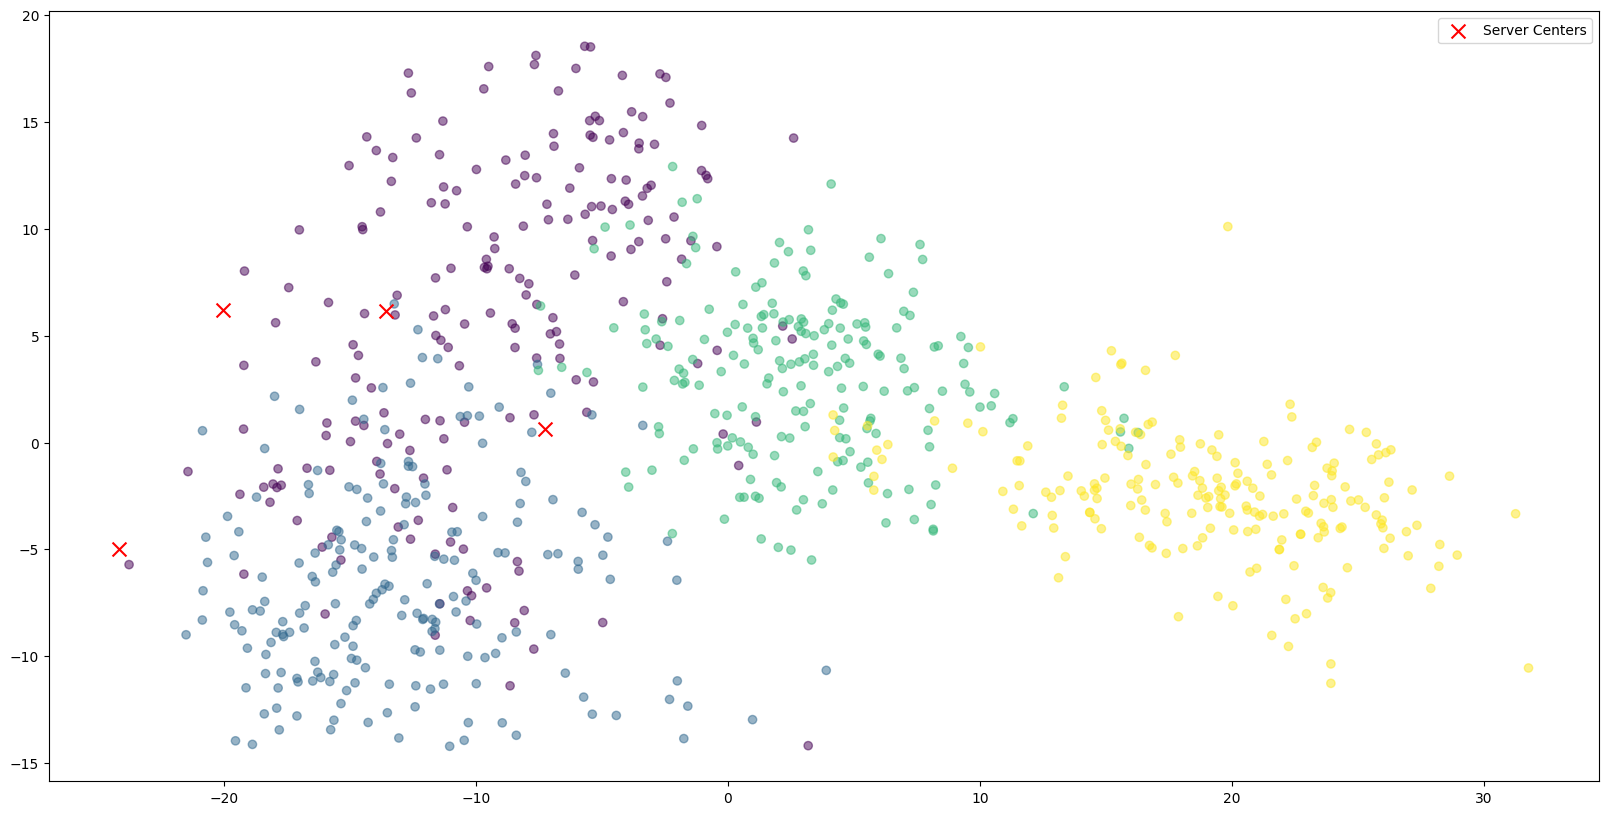

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)


pca_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(20, 10))

plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels_clients, alpha=0.5)

#pca_embeddings_centers = pca.transform(centers)
#plt.scatter(pca_embeddings_centers[:, 0], pca_embeddings_centers[:, 1], c='k', marker='x', s=500, label='Cluster Centers')

#pca_embeddings_client = pca.transform(client_embeddings)
#plt.scatter(pca_embeddings_client[:, 0], pca_embeddings_client[:, 1], alpha=0.5, marker='o', s=50, label='Client Embeddings')

#pca_embeddings_client_0 = pca.transform(embeddings_client_sim)
#plt.scatter(pca_embeddings_client_0[:, 0], pca_embeddings_client_0[:, 1], c=embeddings_client_labels, alpha=0.8, s=50, label='Client 0 Embeddings')

#pca_embeddings_centers_inferred = pca.transform(center_client)
#plt.scatter(pca_embeddings_centers_inferred[:, 0], pca_embeddings_centers_inferred[:, 1], c='g', marker='x', s=500, label='Inferred Centers', alpha=1)


pca_embeddings_centers_inferred = pca.transform(centers_server)
plt.scatter(pca_embeddings_centers_inferred[:, 0], pca_embeddings_centers_inferred[:, 1], c='r', marker='x', s=100, label='Server Centers', alpha=1)


#path = 'output_aya/baselines_new_evals/SmolLM-135M/ROUTER_single_domain_aya_dataset_router_c10s10_i10_b16a1_l1024_r8a16_20250702091304/centers/client_embeddings_1.npy'
#plt.xlim(-5, 20)
#plt.ylim(-10, 10) 
plt.legend()

In [24]:
def clusterize_dataset(embeddings, centroids):

    infered_labels = []

    for e in embeddings:
        #e = e.reshape(1, -1)
        distances = np.linalg.norm(centroids - e, axis=1)
        #similarities = np.dot(centroids, e) / (np.linalg.norm(centroids, axis=1) * np.linalg.norm(e))
        closest_centroid = np.argmax(distances)
        infered_labels.append(closest_centroid)
    
    return np.array(infered_labels)

In [25]:
for i in range(10):
    print(np.unique(clusterize_dataset(embeddings_client_sim, centers)[100*i:100*(i+1)], return_counts=True))


(array([0, 1, 3]), array([10, 51, 39]))
(array([0, 1, 3]), array([13, 41, 46]))
(array([0, 2, 3]), array([53,  1, 46]))
(array([0, 3]), array([37, 63]))
(array([1, 2, 3]), array([79, 10, 11]))
(array([1, 2, 3]), array([75, 16,  9]))
(array([1, 2]), array([92,  8]))
(array([1, 2]), array([92,  8]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [26]:
[1, 1, 2, 2, 0, 0, 3, 3, 4, 4]

[1, 1, 2, 2, 0, 0, 3, 3, 4, 4]